In [508]:
from itertools import islice

import argparse

from tqdm import tqdm
import numpy as np
import torch
import torch.utils.data

import torchvision
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
from torch.nn import functional as F

from torchvision import datasets, transforms

from torchvision.utils import save_image

# from models import VAE

# import visdom


def get_data_loaders(path,
                     resize=(200, 200),
                     batch_size=16,
                     shuffle=True,
                     small=False):
    ds = datasets.ImageFolder(
        path,
        transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor(),
        ]))

    ds_size = len(ds)
    if small:
        ds_size = int(ds_size * 0.1)

    # TODO, we should probably split in a way that is sensitive
    # to time series. We don't want to put data into validation that
    # is extremely close data in train (due to being very close in time).
    indices = list(range(ds_size))
    np.random.shuffle(indices)

    split = int(np.floor(0.7 * ds_size))

    train_indices, test_indices = indices[:split], indices[split:]

    # Creating PT data samplers and loaders.
    train_sampler = SubsetRandomSampler(train_indices)
    test_ds = torch.utils.data.Subset(ds, test_indices)

    train_loader = torch.utils.data.DataLoader(ds,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_ds,
                                              batch_size=batch_size,
                                              pin_memory=True)

    return train_loader, test_loader


# NOTE: Took this from:
# https://github.com/pytorch/examples/blob/master/vae/main.py
# Some modifications:
# 1. Clamped the inputs to binary_cross_entropy in attempt to avoid a bug.
def loss_function(recon_x, x, mean, logvar):
    BCE = F.binary_cross_entropy(torch.clamp(recon_x, 0.000001, 0.999999),
                                 torch.clamp(x.view(-1, 3 * 200 * 200),
                                             0.000001, 0.999999),
                                 reduction='sum')

    KLD_weight = 5.0
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return BCE + (KLD * KLD_weight)


def train(epoch, device, model, optimizer, train_loader, vis):
    model.train()

    total_loss = 0
    zs = []
    for i, (data, _) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        X = data.to(device)

        y, mean, logvar, z = model(X)

        zs.extend(z.detach().cpu().numpy())
        loss = loss_function(y, X, mean, logvar)
        total_loss += loss.detach().cpu().numpy()
        loss.backward()
        optimizer.step()

        if (i / len(train_loader)) > 0.2:
            # leave early due to weird problems. shuffling helps, save more.
            break

    print('embedding')
    print(np.array(zs[:200]).shape)
    tsne_embedding(vis, np.array(zs), 'train embedding')
    print('done embedding')
    print('total_loss', total_loss)

    return total_loss / len(train_loader)


def tsne_embedding(vis, zs, name):
    pass
    #import numpy as np
    #from sklearn.manifold import TSNE
    #X_embedded = TSNE(n_components=2).fit_transform(zs)
    #vis.scatter(X_embedded, name=name)


def test(epoch, device, model, test_loader, vis):
    model.eval()

    total_loss = 0
    zs = []
    with torch.no_grad():
        for i, (data, _) in tqdm(enumerate(test_loader)):
            X = data.to(device)
            y, mean, logvar, z = model(X)
            zs.extend(z.cpu().numpy())
            total_loss += loss_function(y, X, mean, logvar).cpu().numpy()

            if i == 0:
                # For the same first batch of validation, emit the images.
                unstacked_y = y.view(X.shape).cpu()
                stacked_image = torch.cat((X.cpu(), unstacked_y), dim=0)
                torchvision.utils.save_image(
                    torchvision.utils.make_grid(stacked_image),
                    f'validate{epoch:04}.png')
                vis.images(stacked_image, opts=dict(caption=f'epoch {epoch}'))

            if (i / len(test_loader)) > 0.2:
                break

    print('embedding')
    print(np.array(zs[:200]).shape)
    tsne_embedding(vis, np.array(zs), 'test embedding')
    print('done embedding')
    print('total_loss', total_loss)
    return total_loss / len(test_loader)


def load_state(path, model, optimizer):
    try:
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
    except FileNotFoundError:
        epoch = 0

    return epoch


def save_model(path, model, optimizer, epoch):
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, path)


def main():
    parser = argparse.ArgumentParser(description='Train a VAE of sheep')
    parser.add_argument('model_path')
    parser.add_argument('data_path')
    parser.add_argument('--small', type=bool, default=False)

    args = parser.parse_args()

    device = torch.device("cuda")

    model = VAE(latent_size=4).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    epoch = load_state(args.model_path, model, optimizer)

    train_data_loader, test_data_loader = get_data_loaders(args.data_path,
                                                           small=args.small,
                                                           batch_size=128)

    vis = visdom.Visdom()

    epochs = []
    metrics = {'train': [], 'test': []}

    while epoch < 100:
        print('epoch', epoch)

        epoch += 1
        epochs.append(epoch)
        metrics['train'].append(
            train(epoch, device, model, optimizer, train_data_loader, vis))

        save_model(args.model_path, model, optimizer, epoch)

        metrics['test'].append(
            test(epoch, device, model, test_data_loader, vis))

        Y = np.array([metrics['train'], metrics['test']]).T
        vis.line(X=epochs,
                 Y=Y,
                 opts=dict(title=f'epoch {epoch}', legend=['Train', 'Test']))


# if __name__ == '__main__':
#     main()


In [509]:
import torch

from torch import nn


class VAE(nn.Module):
    '''Simple VAE network, based on the example VAE found in 
    the pytorch examples.
    '''

    def __init__(self, image_w=200, image_h=200, latent_size=30):
        super(VAE, self).__init__()

        self._image_w = image_w
        self._image_h = image_h
        self._latent_size = latent_size

        # Encoder layer into latent space.
        self._encoder = nn.Sequential(
            nn.Linear(3 * self._image_w * self._image_h, 400), nn.ReLU())

        # Latent space to prob space
        self._mean = nn.Linear(400, self._latent_size)
        self._std = nn.Linear(400, self._latent_size)

        # Latent space to decoded space.
        self._decoder = nn.Sequential(
            nn.Linear(self._latent_size, 400), nn.ReLU(),
            nn.Linear(400, 3 * self._image_w * self._image_h), nn.Sigmoid())

    def encode(self, x):
        h1 = self._encoder(x)
        return self._mean(h1), self._std(h1)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        return self._decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(
            x.view(-1, 3 * self._image_w * self._image_h))
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar, z


In [525]:
train_data_loader, test_data_loader = get_data_loaders(path='../../_data/', resize=(64, 64), batch_size=6)

In [526]:
real_batch = next(iter(train_data_loader))

In [527]:
import torchvision.utils as vutils

In [528]:
import matplotlib.pyplot as plt

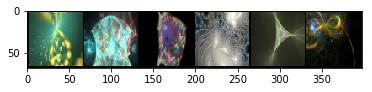

In [529]:
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2, normalize=False), (1, 2, 0)))

In [530]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [531]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [532]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [533]:
batch_size = 128
image_size = 64
nc = 3
nz = 20
ngf = 32
ndf = 32
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 0

In [534]:
train_data_loader, test_data_loader = get_data_loaders(path='../../_data/', resize=(image_size, image_size), batch_size=batch_size)


In [535]:
netG = Generator(ngpu)
netG.apply(weights_init);

In [536]:
netD = Discriminator(ngpu)
netD.apply(weights_init);

In [537]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [538]:
device = torch.device('cpu')

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 100
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the train_data_loader
    for i, data in enumerate(train_data_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_data_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        

Starting Training Loop...
[0/100][0/662]	Loss_D: 1.1558	Loss_G: 2.2989	D(x): 0.7640	D(G(z)): 0.5432 / 0.1217
[0/100][50/662]	Loss_D: 1.0841	Loss_G: 1.5918	D(x): 0.4746	D(G(z)): 0.1686 / 0.2246
[0/100][100/662]	Loss_D: 0.4587	Loss_G: 3.1227	D(x): 0.7692	D(G(z)): 0.1546 / 0.0542
[0/100][150/662]	Loss_D: 1.0090	Loss_G: 5.3461	D(x): 0.8541	D(G(z)): 0.5268 / 0.0065
[0/100][200/662]	Loss_D: 0.4814	Loss_G: 4.1198	D(x): 0.6526	D(G(z)): 0.0183 / 0.0275
[0/100][250/662]	Loss_D: 0.5931	Loss_G: 2.7732	D(x): 0.9095	D(G(z)): 0.3670 / 0.0738
[0/100][300/662]	Loss_D: 1.0296	Loss_G: 1.8505	D(x): 0.6042	D(G(z)): 0.3746 / 0.1771
[0/100][350/662]	Loss_D: 0.9666	Loss_G: 1.9287	D(x): 0.6271	D(G(z)): 0.3570 / 0.1571
[0/100][400/662]	Loss_D: 1.0223	Loss_G: 0.6633	D(x): 0.4497	D(G(z)): 0.1282 / 0.5352


In [ ]:
noise = torch.randn(1, nz, 1, 1, device=device)
# Generate fake image batch with G
fake = netG(noise)

In [ ]:
plt.imshow(np.transpose(fake[0].detach().numpy(), (1, 2, 0)))

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
